In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
def portrr_df(returnDF, startQuarter, endQuarter):
    #load portfolios
    rr_df = pd.read_csv('/home/jpreszler/github/insight-project/mvp_app/static/3d-portfolios-nz.csv')
    #select return subset
    returns_small = returnDF[(returnDF['Quarter']>=startQuarter) & (returnDF['Quarter']<=endQuarter)]

    #compute portfolio return
    rr_df['return'] = rr_df['stock weight']*returns_small['Equities'].mean()+rr_df['bond weight']*returns_small['Bonds'].mean()+rr_df['real estate weight']*returns_small['Real Estate'].mean()

    #compute risk for portfolio
    rr_df['risk'] = (rr_df['stock weight']*returns_small['Equities'].std())**2+(rr_df['bond weight']*returns_small['Bonds'].std())**2+(rr_df['real estate weight']*returns_small['Real Estate'].std())**2+2*rr_df['stock weight']*rr_df['bond weight']*returns_small['Equities'].cov(returns_small['Bonds'])+2*rr_df['stock weight']*rr_df['real estate weight']*returns_small['Equities'].cov(returns_small['Real Estate'])+2*rr_df['bond weight']*rr_df['real estate weight']*returns_small['Bonds'].cov(returns_small['Real Estate'])
    rr_df['risk'] = np.sqrt(rr_df['risk']).round(decimals=4)

    return(rr_df)

def get_opt_port(port_df, lower_risk, upper_risk):
    risk_band = port_df[(port_df['risk']>=lower_risk) & (port_df['risk']<=upper_risk)]
    max_return_in_band = risk_band['return'].max()
    return(risk_band[risk_band['return']==max_return_in_band])

def port_tsdf(portfolio, opt_portfolio, returnsDF, startQuarter, endQuarter):
    returns_small = returnsDF[(returnsDF['Quarter']>=startQuarter) & (returnsDF['Quarter']<=endQuarter)].copy()
    returns_small['Current Portfolio'] = returns_small['Equities']*portfolio['stock weight'].values+returns_small['Bonds']*portfolio['bond weight'].values
    returns_small['Optimal Portfolio'] = returns_small['Equities']*opt_portfolio['stock weight'].values+returns_small['Bonds']*opt_portfolio['bond weight'].values+returns_small['Real Estate']*opt_portfolio['real estate weight'].values
    return(returns_small[['Quarter', 'Current Portfolio', 'Optimal Portfolio']])

def port_future_tsdf(portfolio, opt_portfolio, returnsDF, startQuarter):
    returns_small = returnsDF[(returnsDF['Quarter']>=startQuarter)].copy()
    returns_small['Current Portfolio'] = returns_small['Equities']*portfolio['stock weight'].values+returns_small['Bonds']*portfolio['bond weight'].values
    returns_small['Optimal Portfolio'] = returns_small['Equities']*opt_portfolio['stock weight'].values+returns_small['Bonds']*opt_portfolio['bond weight'].values+returns_small['Real Estate']*opt_portfolio['real estate weight'].values
    return(returns_small[['Quarter', 'Current Portfolio', 'Optimal Portfolio']])

def draw_perform_compare(port_ts_df):
    port_ts_df['Current Portfolio Cumulative'] = port_ts_df['Current Portfolio'].cumsum()
    port_ts_df['Optimal Portfolio Cumulative'] = port_ts_df['Optimal Portfolio'].cumsum()
    
    #g = sns.lineplot(x='Quarter', y='value', hue='variable', data=pd.melt(port_ts_df, id_vars=['Quarter'], value_vars = ['Equities', 'Bonds', 'Real Estate', 'Portfolio']))
    g= sns.lineplot(x='Quarter', y='value', hue='variable', data=pd.melt(port_ts_df, id_vars=['Quarter'], value_vars=['Current Portfolio Cumulative', 'Optimal Portfolio Cumulative']))
    return g

def draw_port_cloud(port_df, color='Max Wt Category'):
    eff_cloud = sns.scatterplot(x='risk', y='return', hue=color, data=port_df)
    quantiles = port_df['risk'].quantile([.2,.4,.6,.8])
    max_ret = port_df['return'].max()
    eff_cloud.axvline(x=quantiles[0.2], ymin=0,ymax=max_ret, c='black')
    eff_cloud.axvline(x=quantiles[0.4], ymin=0,ymax=max_ret, c='black')
    eff_cloud.axvline(x=quantiles[0.6], ymin=0,ymax=max_ret, c='black')
    eff_cloud.axvline(x=quantiles[0.8], ymin=0,ymax=max_ret, c='black')
    plt.show()


In [4]:
ret2=pd.read_csv('/home/jpreszler/github/insight-project/mvp_app/static/asset-returns-quarterly.csv')
ret2.head()

,Quarter,Equities,Bonds,Real Estate
0,1978Q1,-4.93,0.59,3.336949
1,1978Q2,8.50,0.01,2.859398
2,1978Q3,8.66,2.20,2.950872
3,1978Q4,-4.93,-0.98,4.901429
4,1979Q1,7.08,2.89,3.061083


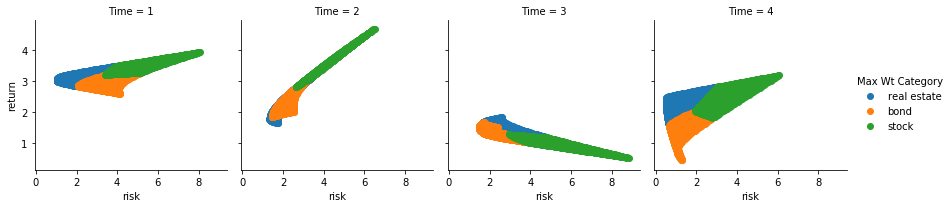

In [5]:
first = portrr_df(ret2, '1978Q1', '1988Q4')
second = portrr_df(ret2, '1989Q1', '1999Q4')
third = portrr_df(ret2, '2000Q1', '2010Q4')
fourth = portrr_df(ret2, '2011Q1', '2019Q1')

first['Time'] = '1'
second['Time'] = '2'
third['Time'] = '3'
fourth['Time'] = '4'
timerr = pd.concat([first, second, third, fourth])
g = sns.FacetGrid(timerr, col='Time', hue='Max Wt Category')
g = g.map(plt.scatter, 'risk', 'return').add_legend()

In [6]:
test_df = portrr_df(ret2, '2011Q1', '2013Q4')
testQuants = list(test_df['risk'].quantile([0,.2,.4,.6,.8,1]))
test = get_opt_port(test_df, testQuants[1], testQuants[2])
test_df.head()

,stock weight,bond weight,real estate weight,Max Wt Category,return,risk
0,0.01,0.01,0.98,real estate,2.668739,0.3742
1,0.01,0.02,0.97,real estate,2.648877,0.3742
2,0.01,0.03,0.96,real estate,2.629016,0.3752
3,0.01,0.04,0.95,real estate,2.609155,0.3773
4,0.01,0.05,0.94,real estate,2.589293,0.3804


In [8]:
test2d = pd.DataFrame({'stock weight': .30, 'bond weight': .70}, index=[0])
port_comp = port_tsdf(test2d, test,ret2, '2011Q1', '2013Q4')
port_comp.describe()

,Current Portfolio,Optimal Portfolio
count,12.000000,12.000000
mean,1.708083,2.908954
std,1.428205,1.297018
min,-0.443000,-0.020488
25%,0.745500,2.469774
50%,1.688000,2.968879
75%,2.750750,4.007484
max,4.134000,4.306703


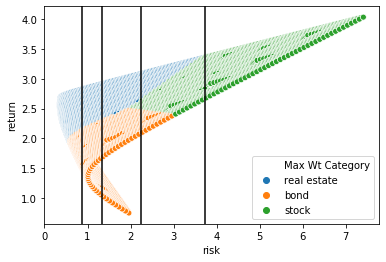

In [14]:
draw_port_cloud(test_df)

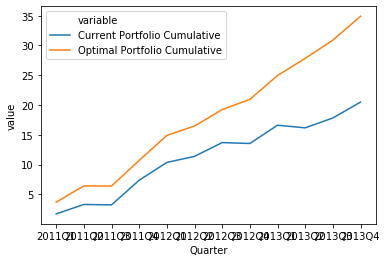

In [11]:
draw_perform_compare(port_comp)

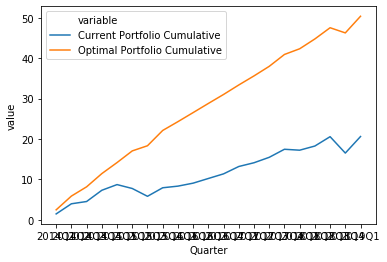

In [13]:
port_comp_future = port_future_tsdf(test2d, test, ret2, '2014Q1')
draw_perform_compare(port_comp_future)